<a href="https://colab.research.google.com/github/Nischith7102005/living-dataset/blob/main/mainfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset-specific parameter controls (edit these for your data)
PARAMS = {
    # Iris dataset ranges (example - adjust for your dataset)
    'feature_ranges': {
        'sepal length (cm)': {'min': 4.0, 'max': 8.0},
        'sepal width (cm)': {'min': 2.0, 'max': 4.5},
        'petal length (cm)': {'min': 1.0, 'max': 7.0},
        'petal width (cm)': {'min': 0.1, 'max': 2.5}
    },
    # Synthesis controls
    'noise_scale': 0.05,
    'generations': 5,
    'pop_size': None,  # None = match training set size
    'test_size': 0.2,
    'random_state': 42
}

In [2]:
# Load dataset (replace with your CSV)
# df = pd.read_csv('yourfile.csv')
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target_names[iris.target], name='species')

print("Original dataset shape:", X.shape)
print("First 5 rows:")
print(X.head())

Original dataset shape: (150, 4)
First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=PARAMS['test_size'],
    random_state=PARAMS['random_state'],
    stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 120 samples
Test set: 30 samples


In [4]:
orig_model = LogisticRegression(max_iter=1000)
orig_model.fit(X_train, y_train)
orig_pred = orig_model.predict(X_test)
orig_acc = accuracy_score(y_test, orig_pred)
orig_f1 = f1_score(y_test, orig_pred, average='weighted')

print("\n=== ORIGINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {orig_acc:.3f}")
print(f"F1 Score: {orig_f1:.3f}")


=== ORIGINAL MODEL PERFORMANCE ===
Accuracy: 0.967
F1 Score: 0.967


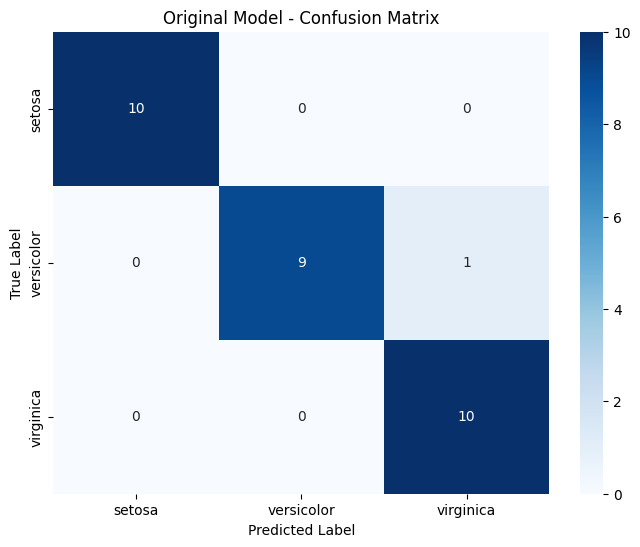

In [5]:
cm = confusion_matrix(y_test, orig_pred, labels=iris.target_names)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=iris.target_names, columns=iris.target_names),
            annot=True, fmt='d', cmap='Blues')
plt.title("Original Model - Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('original_confusion.png', dpi=150)
plt.show()

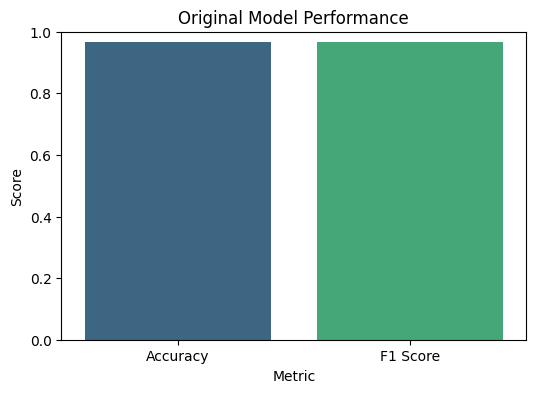

In [6]:
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Score': [orig_acc, orig_f1]
})
plt.figure(figsize=(6,4))
sns.barplot(data=metrics, x='Metric', y='Score', hue='Metric', palette='viridis', legend=False)
plt.title("Original Model Performance")
plt.ylim(0, 1)
plt.savefig('original_metrics.png', dpi=150)
plt.show()

In [7]:
class Flower:
    def __init__(self, numbers):
        self.numbers = np.array(numbers, dtype=float)
        self.fitness = 0.0

def mutate(flower, noise_size=PARAMS['noise_scale']):
    # Clip mutations to stay within feature ranges
    new_numbers = flower.numbers + np.random.normal(0, noise_size, flower.numbers.shape)
    for i, col_name in enumerate(X.columns):
        new_numbers[i] = np.clip(
            new_numbers[i],
            PARAMS['feature_ranges'][col_name]['min'],
            PARAMS['feature_ranges'][col_name]['max']
        )
    return Flower(new_numbers)

def crossover(flower1, flower2):
    alpha = np.random.rand()
    child_numbers = alpha * flower1.numbers + (1 - alpha) * flower2.numbers
    return Flower(child_numbers)

def score_flowers(flowers, model, X_train, y_train):
    X_pop = np.array([f.numbers for f in flowers])
    model.fit(X_pop, y_train)
    preds = model.predict(X_pop)
    acc = accuracy_score(y_train, preds)
    for f in flowers:
        f.fitness = acc
    return acc

def evolve_population(flowers, model, X_train, y_train, gens=PARAMS['generations']):
    for gen in range(gens):
        best_acc = score_flowers(flowers, model, X_train, y_train)
        print(f"Gen {gen+1}: best accuracy = {best_acc:.3f}")

        flowers.sort(key=lambda f: f.fitness, reverse=True)
        survivors = flowers[:len(flowers)//2]

        children = []
        for _ in range(len(flowers) - len(survivors)):
            mom, dad = np.random.choice(survivors, 2, replace=False)
            child = crossover(mom, dad)
            child = mutate(child)
            children.append(child)

        flowers = survivors + children
    return flowers

In [8]:
starter_flowers = [Flower(row) for row in X_train.values]
model = LogisticRegression(max_iter=1000)

print("\n=== EVOLVING SYNTHETIC DATA ===")
evolved_flowers = evolve_population(starter_flowers, model, X_train, y_train,
                                  gens=PARAMS['generations'])


=== EVOLVING SYNTHETIC DATA ===
Gen 1: best accuracy = 0.975
Gen 2: best accuracy = 0.600
Gen 3: best accuracy = 0.667
Gen 4: best accuracy = 0.658
Gen 5: best accuracy = 0.550


In [9]:
evolved_numbers = np.array([f.numbers for f in evolved_flowers])
evolved_df = pd.DataFrame(evolved_numbers, columns=X.columns)
evolved_df['species'] = y_train.values

# Enforce data types and ranges
for col in X.columns:
    evolved_df[col] = evolved_df[col].astype(float)
    evolved_df[col] = evolved_df[col].clip(
        lower=PARAMS['feature_ranges'][col]['min'],
        upper=PARAMS['feature_ranges'][col]['max']
    )

evolved_df.to_csv("evolved_iris.csv", index=False)
print("\n✓ Saved evolved_iris.csv")
print(f"Synthetic dataset shape: {evolved_df.shape}")


✓ Saved evolved_iris.csv
Synthetic dataset shape: (120, 5)


In [10]:
synth_model = LogisticRegression(max_iter=1000)
synth_model.fit(evolved_df.drop(columns='species'), evolved_df['species'])
synth_pred = synth_model.predict(X_test)
synth_acc = accuracy_score(y_test, synth_pred)
synth_f1 = f1_score(y_test, synth_pred, average='weighted')

print("\n=== SYNTHETIC MODEL PERFORMANCE ===")
print(f"Accuracy: {synth_acc:.3f}")
print(f"F1 Score: {synth_f1:.3f}")
print(f"Improvement: +{synth_acc - orig_acc:.3f} accuracy")


=== SYNTHETIC MODEL PERFORMANCE ===
Accuracy: 0.800
F1 Score: 0.798
Improvement: +-0.167 accuracy


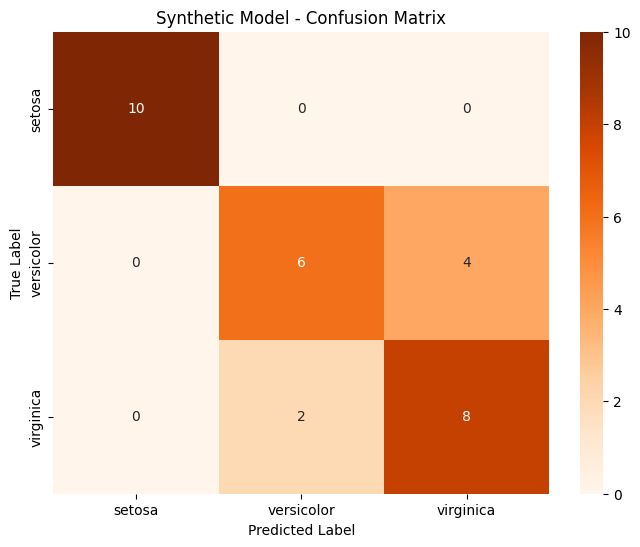

In [11]:
cm_synth = confusion_matrix(y_test, synth_pred, labels=iris.target_names)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm_synth, index=iris.target_names, columns=iris.target_names),
            annot=True, fmt='d', cmap='Oranges')
plt.title("Synthetic Model - Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('synthetic_confusion.png', dpi=150)
plt.show()

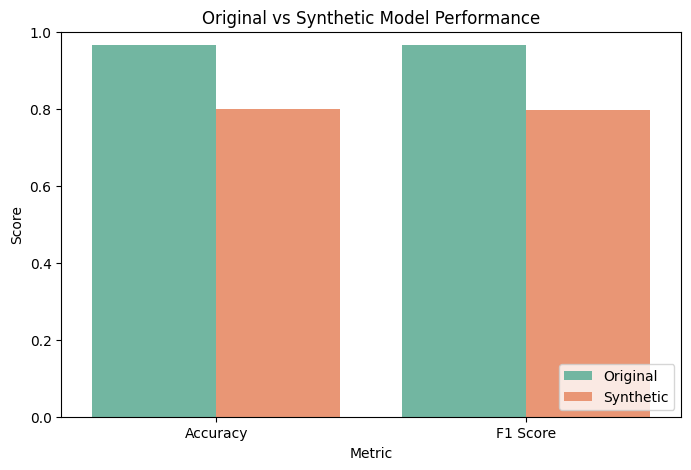

In [12]:
comparison = pd.DataFrame({
    'Model': ['Original', 'Original', 'Synthetic', 'Synthetic'],
    'Metric': ['Accuracy', 'F1 Score', 'Accuracy', 'F1 Score'],
    'Score': [orig_acc, orig_f1, synth_acc, synth_f1]
})
plt.figure(figsize=(8,5))
sns.barplot(data=comparison, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title("Original vs Synthetic Model Performance")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.savefig('comparison_metrics.png', dpi=150)
plt.show()


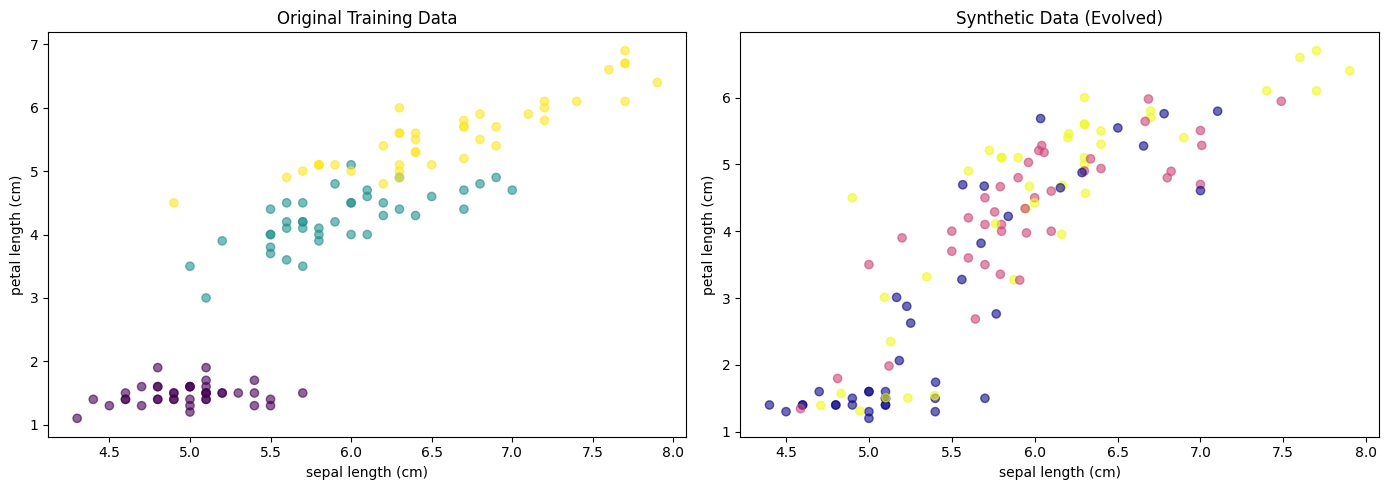

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Original training data
axes[0].scatter(X_train['sepal length (cm)'], X_train['petal length (cm)'],
                c=y_train.map({'setosa':0, 'versicolor':1, 'virginica':2}),
                cmap='viridis', alpha=0.6)
axes[0].set_title("Original Training Data")
axes[0].set_xlabel('sepal length (cm)')
axes[0].set_ylabel('petal length (cm)')

# Synthetic data
axes[1].scatter(evolved_df['sepal length (cm)'], evolved_df['petal length (cm)'],
                c=evolved_df['species'].map({'setosa':0, 'versicolor':1, 'virginica':2}),
                cmap='plasma', alpha=0.6)
axes[1].set_title("Synthetic Data (Evolved)")
axes[1].set_xlabel('sepal length (cm)')
axes[1].set_ylabel('petal length (cm)')

plt.tight_layout()
plt.savefig('data_comparison.png', dpi=150)
plt.show()

In [14]:
print("\n=== DATA RANGE COMPLIANCE CHECK ===")
for col in X.columns:
    min_val = evolved_df[col].min()
    max_val = evolved_df[col].max()
    target_min = PARAMS['feature_ranges'][col]['min']
    target_max = PARAMS['feature_ranges'][col]['max']
    print(f"{col}:")
    print(f"  Range: {min_val:.2f} - {max_val:.2f} (target: {target_min} - {target_max})")
    print(f"  ✓ In bounds" if min_val >= target_min and max_val <= target_max else "  ✗ Out of bounds!")

print("\n=== FILES GENERATED ===")
print("1. evolved_iris.csv - Synthetic dataset")
print("2. original_confusion.png - Original model confusion matrix")
print("3. original_metrics.png - Original model metrics")
print("4. synthetic_confusion.png - Synthetic model confusion matrix")
print("5. comparison_metrics.png - Side-by-side metrics comparison")
print("6. data_comparison.png - 2D scatter plot comparison")


=== DATA RANGE COMPLIANCE CHECK ===
sepal length (cm):
  Range: 4.40 - 7.90 (target: 4.0 - 8.0)
  ✓ In bounds
sepal width (cm):
  Range: 2.00 - 4.40 (target: 2.0 - 4.5)
  ✓ In bounds
petal length (cm):
  Range: 1.20 - 6.70 (target: 1.0 - 7.0)
  ✓ In bounds
petal width (cm):
  Range: 0.10 - 2.50 (target: 0.1 - 2.5)
  ✓ In bounds

=== FILES GENERATED ===
1. evolved_iris.csv - Synthetic dataset
2. original_confusion.png - Original model confusion matrix
3. original_metrics.png - Original model metrics
4. synthetic_confusion.png - Synthetic model confusion matrix
5. comparison_metrics.png - Side-by-side metrics comparison
6. data_comparison.png - 2D scatter plot comparison
